In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale=1.2)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pylab 
import scipy.stats as stats

In [2]:
!ls

Datasets
Exploratory_PCA_dmb.ipynb
FractalDimensionWaveform-KaggleHousing.ipynb
ML_Project_KM.ipynb
README.MD
Wenchang_Qian_Kaggle_Ames_Iowa_Housing_Price_Prediction.ipynb
james_proj3.ipynb
jamesczq_baseline_regressions.ipynb


In [3]:
!ls Datasets

X_test.csv            test.csv              train_Wenchang.csv
X_train.csv           test_Wenchang.csv     train_j.csv
data_description.txt  test_j.csv            train_test.csv
sample_submission.csv train.csv


In [4]:
# Setting of Flags


# For Section 1: 
# Data Loading ----------------------------------------
#whichDataSet = 0;
whichDataSet = 'w';


# For Section 2: 
# Data Pre-Processing ---------------------------------
use_2_CookedUp_Features = 1;
# Use Bath/Bed and Garage/Bed or not
# 1 means Yes; other numbers mean No. 

use_2_CookedUp_Features_instead = 0;
# Use Bath/Bed and Garage/Bed instead of Bath (Full, Half), Garage
# 1 means Yes; other numbers mean No. 

## 1. Data Loading

In [5]:
if whichDataSet == 0: # Using the original data set 
    train = pd.read_csv('Datasets/train.csv')
    test = pd.read_csv('Datasets/test.csv')
    # Concat. train[no ID column, ... (all columns) ..., no SalePrice column]
    #     with test[no ID column, ... (all columns) ..., no SalePrice column]
    # (Test data has no SalePrice column anyway)
    train_test = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],
                             test.loc[:,'MSSubClass':'SaleCondition']]);
    print('Train-Test mega dataset shape:',train_test.shape)
##
##
if whichDataSet == 'w': # Using Wenchang's modified data set
    train = pd.read_csv('Datasets/train_Wenchang.csv')
    test = pd.read_csv('Datasets/test_Wenchang.csv')
    train.drop(['Unnamed: 0'], axis=1, inplace=True)
    test.drop(['Unnamed: 0'], axis=1, inplace=True)
    train_test = pd.concat([train.loc[:,'1stFlrSF':'RemodYearDiff'],
                             test.loc[:,'1stFlrSF':'RemodYearDiff']]);
    print('Train-Test mega dataset shape:',train_test.shape)

Train-Test mega dataset shape: (2919, 72)


In [6]:
#train.head().T

In [7]:
#test.head().T

In [8]:
#train.info()

## 2. Data Pre-Processing
* 2.0 (Optional) Add Cooked_up Features: Bath_Capacity and Parking_Capacity
* 2.1 Some Preliminary Examination and Symmetrization
* 2.2 Fill in NAs
* 2.3 Encode Categorical Features
* 2.4 Set up training and test data matrices

### 2.0 (Optional) Add Cooked_up Features: Bath_Capacity and Parking_Capacity

In [9]:
# Zero bedroom or zero garage parking spaces or zero bathroom may give trouble
# to derived features such as bath/bed
# Need to think about a way to walk around this

print('*'*50)
print('For Training Data Set:')
print('*'*50)
print('Num of houses with Zero Bedroom:',\
      sum(train.BedroomAbvGr==0))
print('Num of houses with Zero Garage Parking:',\
      sum(train.GarageCars==0))
print('Num of houses with Neither Half Nor Full Bath:',\
      sum((train.HalfBath==0) & (train.FullBath==0)))
print('*'*50)
print('For Test Data Set:')
print('*'*50)
print('Num of houses with Zero Bedroom:',\
      sum(test.BedroomAbvGr==0))
print('Num of houses with Zero Garage Parking:',\
      sum(test.GarageCars==0))
print('Num of houses with Neither Half Nor Full Bath:',\
      sum((test.HalfBath==0) & (train.FullBath==0)))

**************************************************
For Training Data Set:
**************************************************
Num of houses with Zero Bedroom: 6
Num of houses with Zero Garage Parking: 81
Num of houses with Neither Half Nor Full Bath: 3
**************************************************
For Test Data Set:
**************************************************
Num of houses with Zero Bedroom: 2
Num of houses with Zero Garage Parking: 76
Num of houses with Neither Half Nor Full Bath: 6


In [10]:
if use_2_CookedUp_Features == 1:
    #
    # Compute Total Bathrooms in a house
    # and set those with zero bathroom with median bathroom number
    train['TotBath'] = train.FullBath + 0.5*train.HalfBath;
    test['TotBath'] = test.FullBath + 0.5*test.HalfBath;
    train_test['TotBath'] = train_test.FullBath + 0.5*train_test.HalfBath;
    #
    train['TotBath'].replace(0, train['TotBath'].median(), inplace=True);
    test['TotBath'].replace(0, test['TotBath'].median(), inplace=True);
    train_test['TotBath'].replace(0, train_test['TotBath'].median(), inplace=True);
    #------------------------------------------------------------------------------
    #
    # Set those with zero bedroom with median bedfroom number 
    # (or set them to one to be conservative)
    train['BedroomAbvGr'].replace(0, train['BedroomAbvGr'].median(), inplace=True);
    test['BedroomAbvGr'].replace(0, test['BedroomAbvGr'].median(), inplace=True);
    train_test['BedroomAbvGr'].replace(0, train_test['BedroomAbvGr'].median(), inplace=True);
    #------------------------------------------------------------------------------
    #
    # Cook-up Feature 1:
    # Bath_Capacity = TotBath / BedroomAbvGr
    train['Bath_Capacitance'] = train.TotBath / train.BedroomAbvGr
    test['Bath_Capacitance'] = train.TotBath / train.BedroomAbvGr
    train_test['Bath_Capacitance'] = train.TotBath / train.BedroomAbvGr
    #------------------------------------------------------------------------------
    #
    # Cook-up Feature 2: 
    # Parking_Capacity = TotBath / BedroomAbvGr
    train['Parking_Capacitance'] = train.GarageCars / train.BedroomAbvGr
    test['Parking_Capacitance'] = train.GarageCars / train.BedroomAbvGr
    train_test['Parking_Capacitance'] = train.GarageCars / train.BedroomAbvGr

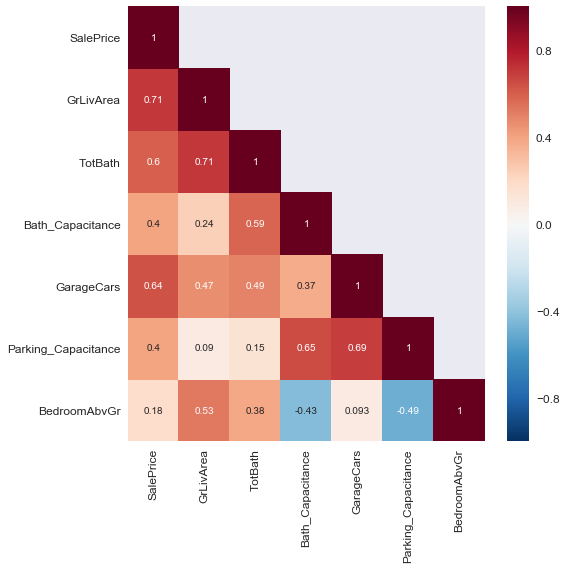

In [11]:
# Show that the cooked-up features are correlated to SalePrice non-trivially
# e.g.: Corr(Price, Bath_Capacitance) vs {Corr(Price, totBath), Corr(Price, Bedroom)}
# The GrLivArea is brought up as a benchmark 
# (Corr(Price, GrLivArea) = 0.71 which is quite large)

if use_2_CookedUp_Features == 1:
    # Examine whether the cook-up features have some merit
    fig, ax = plt.subplots(ncols=1, figsize = (8,8));
    d = train[['SalePrice',
               'GrLivArea',
               'TotBath',
               'Bath_Capacitance',
               'GarageCars',
               'Parking_Capacitance',
               'BedroomAbvGr']].corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(d, dtype=np.bool)
    mask[np.triu_indices_from(mask, k = 1)] = True
    
    g = sns.heatmap(d, mask=mask, annot=True)
    sns.set(font_scale = 1.5)

In [12]:
if use_2_CookedUp_Features_instead == 1:
    #
    # Reasonable dropping ---------------------------------------- 
    #
    train.drop(train[['FullBath', 
                      'HalfBath']], axis=1, inplace=True)
    test.drop(test[['FullBath', 
                    'HalfBath']], axis=1, inplace=True)
    train_test.drop(train_test[['FullBath', 
                                'HalfBath']], axis=1, inplace=True)
    #
    # Dropping that needs more scrutiny ---------------------------------------- 
    #
    #train.drop(train[['TotBath']], axis=1, inplace=True)
    #test.drop(test[['TotBath']], axis=1, inplace=True)
    #train_test.drop(train_test[['TotBath']], axis=1, inplace=True)
    # Dropping that needs more scrutiny ---------------------------------------- 
    #
    #train.drop(train[['GarageCars']], axis=1, inplace=True)
    #test.drop(test[['GarageCars']], axis=1, inplace=True)
    #train_test.drop(train_test[['GarageCars']], axis=1, inplace=True)

### 2.1 (a) Preliminary Examination

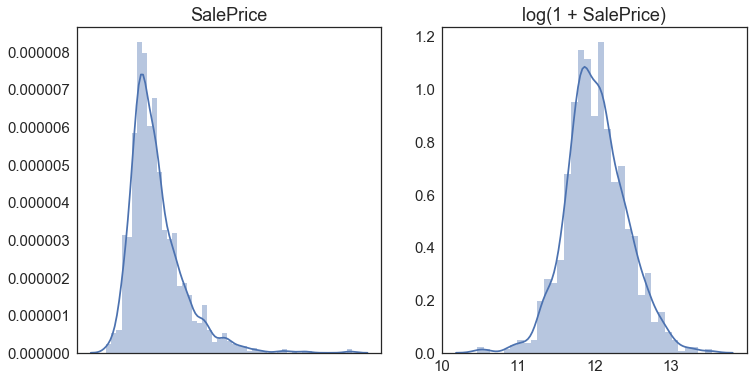

In [13]:
sns.set_style("white")
#sns.set(font_scale=1.2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,6));
sns.distplot(           train.SalePrice,  ax=ax1);
sns.distplot(np.log(1 + train.SalePrice), ax=ax2);

# Turn off ax1(left panel) x-ticks; not intelligible anyway
ax1.xaxis.set_major_locator(plt.NullLocator());
ax1.set_xlabel('');
ax1.set_title('SalePrice');

ax2.set_xlabel('');
ax2.set_title('log(1 + SalePrice)');

In [14]:
# As observed, symmetrize SalePrice via log(1 + ***)
train.SalePrice = np.log(1 + train.SalePrice)

### 2.1 (b) Symmetrization

In [15]:
# Likewise, log transform those skewed numeric features
from scipy.stats import skew

# Set the threshold for being over-skewed
# (can tune later)
skew0 = 0.6;

There are 27 numerical features (out of 37) deemed to be skewed.


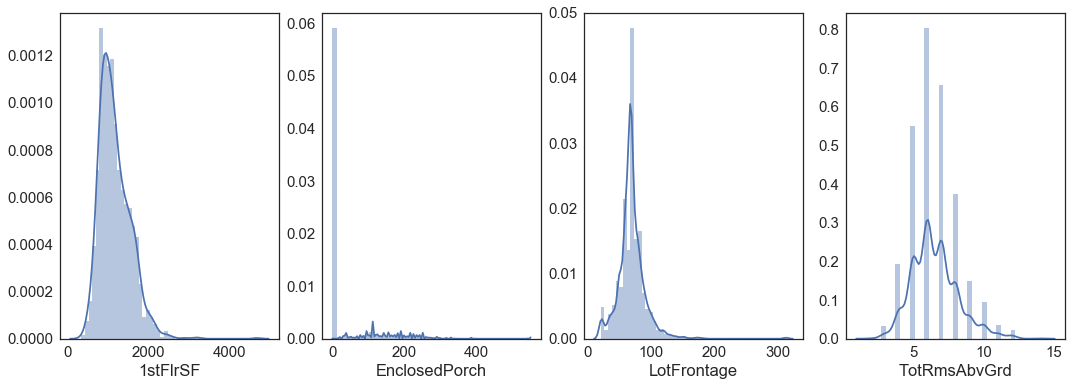

In [16]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna())) 
skewed_features = skewed_features[abs( skewed_features ) > skew0]
skewed_features = skewed_features.index

# look at four of them
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize = (18,6));
sns.distplot(train[skewed_features[0]], ax=ax1);
sns.distplot(train[skewed_features[6]], ax=ax2);
sns.distplot(train[skewed_features[12]], ax=ax3);
sns.distplot(train[skewed_features[18]], ax=ax4);

# Visual examination
print('There are {} numerical features (out of {}) deemed to be skewed.'.\
      format(train[skewed_features].shape[1],numeric_features.shape[0]))

In [17]:
train_test[skewed_features] = np.log(1 + train_test[skewed_features])

### 2.2 Encode Categorical Features
#### Using plain and simple one-hot encoding

In [18]:
train_test = pd.get_dummies(train_test)

In [19]:
#train_test.head().T

### 2.3 Fill in NAs

#### Interpolating NAs with the median of each field

In [20]:
if whichDataSet == 0:
    train_test = train_test.fillna(train_test.median())

### 2.4 Set up training and test data matrices

In [21]:
X_train = train_test[:train.shape[0]]
X_test  = train_test[train.shape[0]:]
y_train = train.SalePrice

## 3. Modeling

### Linear Regression with $L_{1}$ Lasso or $L_{2}$ Ridge Regularizations

In [22]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt( -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(pdSeries0):
    # Specifically, pdSeries0 is a series of Residuals
    rmse = np.sqrt( sum(pdSeries0**2) / pdSeries0.size )
    return(rmse)

### 3.1 Try with Ridge 
#### where $\alpha$ is as in $L(\ \vec{\beta} \ ) = MSE + \alpha \cdot \frac{1}{2} ||\ \vec{\beta}\ ||_{L_{2}}$

In [23]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge()

In [24]:
# supply a log-ranged alphas from 10^(-2) to 10^(2)
# total: 60 alphas to do CV
alpha_array = np.logspace(-1,2,64)

cv_Ridge = [rmse_cv(Ridge(alpha = Alpha)).mean() for Alpha in alpha_array]

**************************************************
Ridge CV:
Minumum RMSE 0.1279 
achieved at alpha = 8.0309
**************************************************


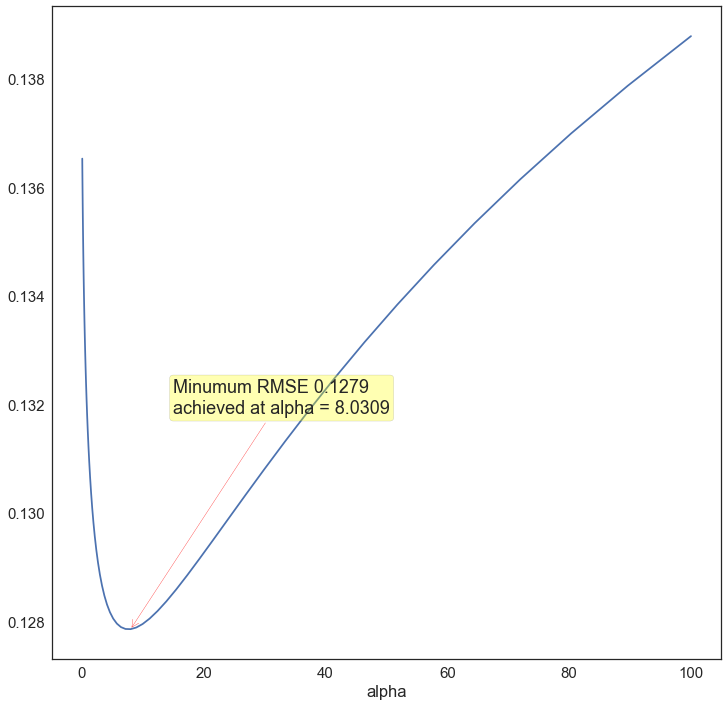

In [25]:
cv_Ridge = pd.Series(cv_Ridge, index = alpha_array)

fig, ax = plt.subplots(figsize=(12,12));
ax.plot(alpha_array,cv_Ridge);
ax.set_xlabel('alpha')
#ax.set_ylabel('RMSE')

alpha0 = cv_Ridge[cv_Ridge == cv_Ridge.min()].index[0];
rmse0 = cv_Ridge.min();

s = 'Minumum RMSE {:.4f} \nachieved at alpha = {:.4f}'.format(rmse0,alpha0)

ax.annotate(s, xy=(alpha0, rmse0),
               xycoords='data',
               xytext=(alpha_array.mean(), cv_Ridge.mean()),
               #textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
               arrowprops=dict(arrowstyle='->',color='red'))

print('*'*50)
print('Ridge CV:')
print(s)
print('*'*50)

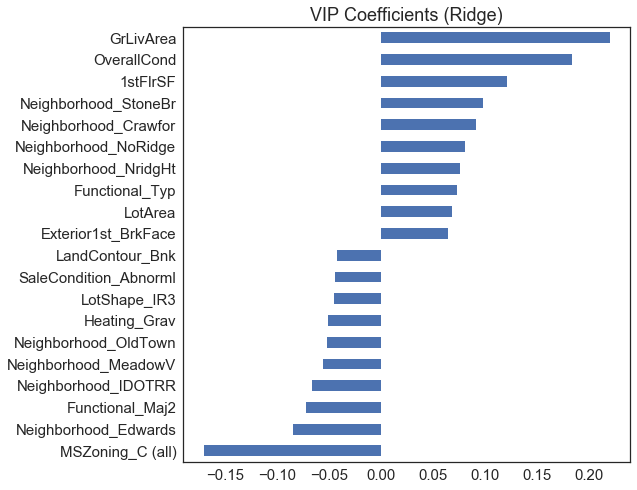

In [26]:
model_Ridge = Ridge(alpha0).fit(X_train, y_train);

coeffs_Ridge = pd.Series(model_Ridge.coef_, index = X_train.columns);
vip_coeffs_Ridge = pd.concat([coeffs_Ridge.sort_values().head(10),
                              coeffs_Ridge.sort_values().tail(10)])

fig, ax = plt.subplots(figsize=(8,8));
vip_coeffs_Ridge.plot(kind = "barh");
plt.title("VIP Coefficients (Ridge)");

**************************************************
Ridge Performace: R^2 = 0.9267
**************************************************
Ridge Performace: RMSE = 0.1081
**************************************************


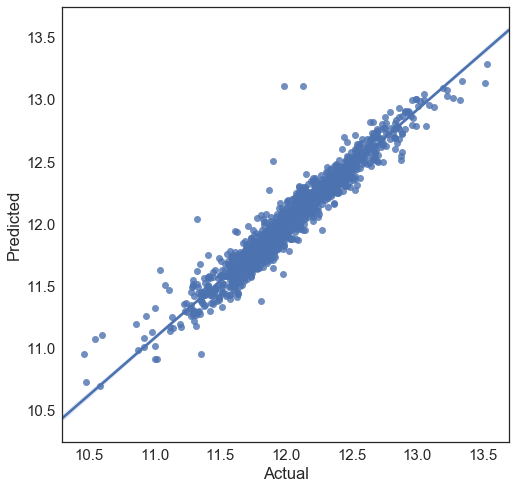

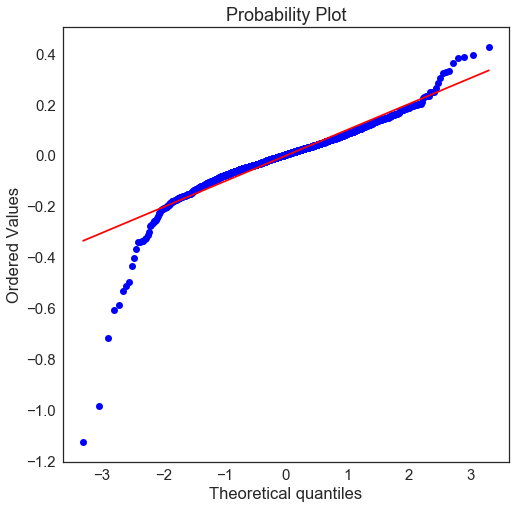

In [27]:
predictions_Ridge = pd.DataFrame({"Predicted":model_Ridge.predict(X_train), 
                                  "Actual":y_train});
predictions_Ridge["Residual"] = predictions_Ridge.Actual - predictions_Ridge.Predicted;


print('*'*50)
print('Ridge Performace: R^2 = {:.4f}'.format(model_Ridge.score(X_train, y_train)))
print('*'*50)
print('Ridge Performace: RMSE = {:.4f}'.format(rmse(predictions_Ridge.Residual)))
print('*'*50)

fig, ax = plt.subplots(figsize=(8,8));
sns.regplot(predictions_Ridge.Actual, predictions_Ridge.Predicted);
#ax.set_title('')

fig, ax = plt.subplots(figsize=(8,8));
stats.probplot(predictions_Ridge.Residual, dist="norm", plot=pylab);
pylab.show();

### 3.2 Try with Lasso 
#### where $\alpha$ is as in $L\left( \vec{\beta} \right) = MSE + \alpha \cdot ||\vec{\beta}||_{L_{1}}$

In [28]:
from sklearn.linear_model import Lasso

model_Lasso = Lasso()

In [29]:
# supply a log-ranged alphas from 10^(-2) to 10^(2)
# total: 60 alphas to do CV
alpha_array = np.linspace(10,0.0005,64)

cv_Lasso = [rmse_cv(Lasso(alpha = Alpha)).mean() for Alpha in alpha_array]

**************************************************
Lasso CV:
Minumum RMSE 0.1236 
achieved at alpha = 0.0005
**************************************************


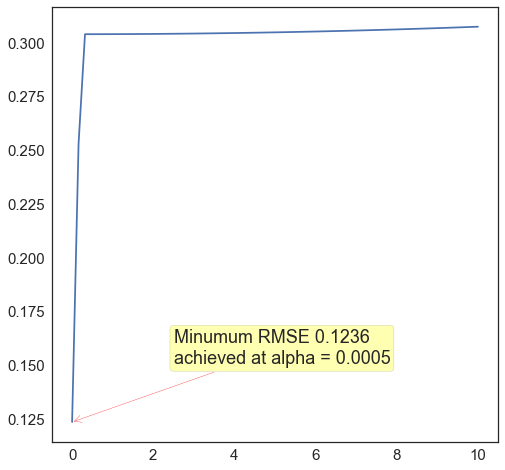

In [30]:
cv_Lasso = pd.Series(cv_Lasso, index = alpha_array)

fig, ax = plt.subplots(figsize=(8,8));
ax.plot(alpha_array,cv_Lasso);

alpha0 = cv_Lasso[cv_Lasso == cv_Lasso.min()].index[0];
rmse0 = cv_Lasso.min();
s = 'Minumum RMSE {:.4f} \nachieved at alpha = {}'.format(rmse0,alpha0)
ax.annotate(s, xy=(alpha0, rmse0),
               xycoords='data',
               xytext=(alpha_array.mean()/2, cv_Lasso.mean()/2),
               #textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
               arrowprops=dict(arrowstyle='->',color='red'))

print('*'*50)
print('Lasso CV:')
print(s)
print('*'*50)

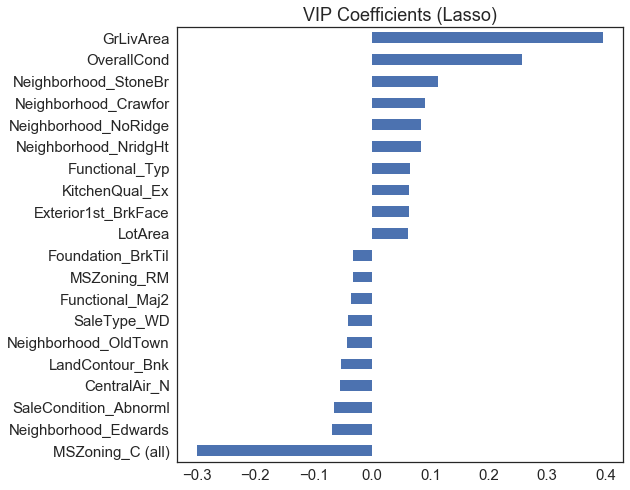

In [31]:
model_Lasso = Lasso(alpha0).fit(X_train, y_train);


coeffs_Lasso = pd.Series(model_Lasso.coef_, index = X_train.columns);
vip_coeffs_Lasso = pd.concat([coeffs_Lasso.sort_values().head(10),
                              coeffs_Lasso.sort_values().tail(10)])

fig, ax = plt.subplots(figsize=(8,8));
vip_coeffs_Lasso.plot(kind = "barh");
plt.title("VIP Coefficients (Lasso)");

**************************************************
Lasso Performace: R^2 = 0.9226
**************************************************
Lasso Performace: RMSE = 0.1111
**************************************************


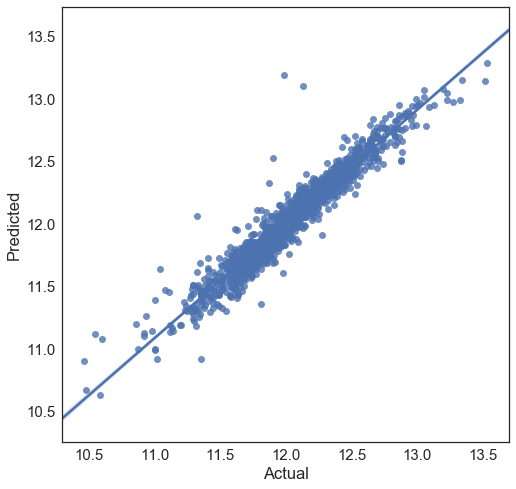

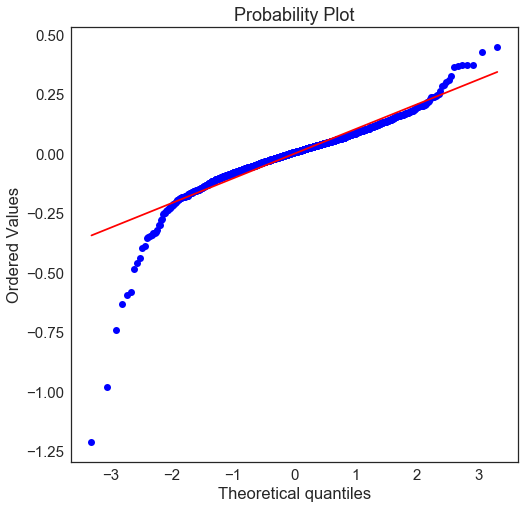

In [32]:
predictions_Lasso = pd.DataFrame({"Predicted":model_Lasso.predict(X_train), 
                                  "Actual":y_train});
predictions_Lasso["Residual"] = predictions_Lasso.Actual - predictions_Lasso.Predicted;

fig, ax = plt.subplots(figsize=(8,8));
sns.regplot(predictions_Lasso.Actual, predictions_Lasso.Predicted);

print('*'*50)
print('Lasso Performace: R^2 = {:.4f}'.format(model_Lasso.score(X_train, y_train)))
print('*'*50)
print('Lasso Performace: RMSE = {:.4f}'.format(rmse(predictions_Lasso.Residual)))
print('*'*50)
#ax.set_title('')

fig, ax = plt.subplots(figsize=(8,8));
stats.probplot(predictions_Lasso.Residual, dist="norm", plot=pylab);
pylab.show();

### 3.3 Try with Elastic Net

### 3.4 Try with XGBoost

In [33]:
import xgboost 

In [34]:
'''
xgboost.XGBRegressor(
    max_depth=3, 
    learning_rate=0.1, 
    n_estimators=100, 
    silent=True, 
    objective='reg:linear', 
    booster='gbtree', 
    n_jobs=1, 
    nthread=None, 
    gamma=0, 
    min_child_weight=1, 
    max_delta_step=0, 
    subsample=1, 
    colsample_bytree=1, 
    colsample_bylevel=1, 
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    base_score=0.5, 
    random_state=0, 
    seed=None, 
    missing=None, 
    **kwargs)
'''

model_xgb = xgboost.XGBRegressor(
                max_depth=4,
                learning_rate=0.05,
                n_estimators=200,
                gamma=0.0,
                min_child_weight=1.5,
                subsample=0.2,
                colsample_bytree=0.2,                                       
                reg_alpha=0.1,
                reg_lambda=0.9,
                seed=42)

model_xgb.fit(X_train, y_train);

In [35]:
predictions_xgb = pd.DataFrame({"Predicted":model_Ridge.predict(X_train), 
                                  "Actual":y_train});
predictions_xgb["Residual"] = predictions_xgb.Actual - predictions_xgb.Predicted;

**************************************************
XGB Performace: RMSE = 0.1081
**************************************************


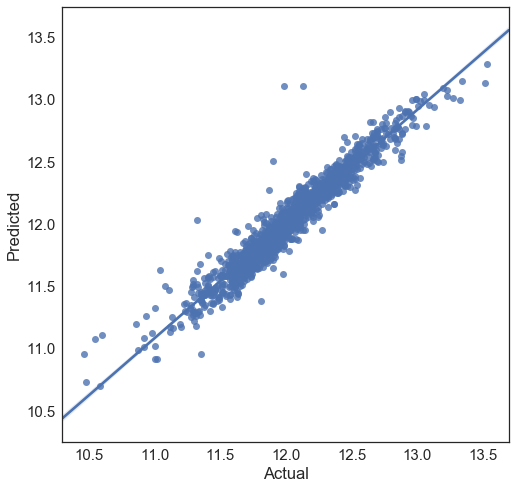

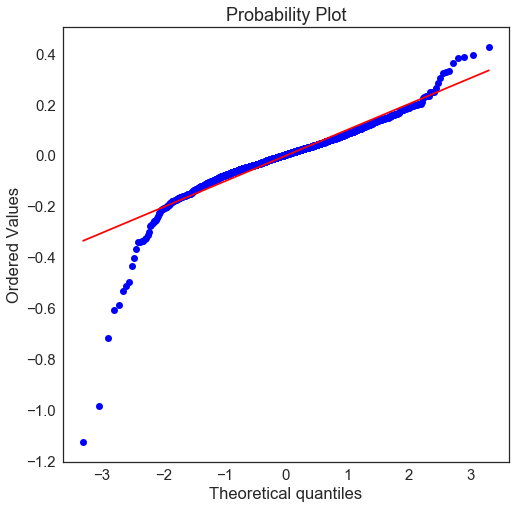

In [36]:
fig, ax = plt.subplots(figsize=(8,8));
sns.regplot(predictions_xgb.Actual, predictions_xgb.Predicted);

print('*'*50)
print('XGB Performace: RMSE = {:.4f}'.format(rmse(predictions_xgb.Residual)))
print('*'*50)

fig, ax = plt.subplots(figsize=(8,8));
stats.probplot(predictions_xgb.Residual, dist="norm", plot=pylab);
pylab.show();